In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import joblib

In [2]:
from datetime import datetime

# Update the dateparse function for the format 'dd-mm-yy'
df = pd.read_csv('updated_file.csv')
df = df.dropna() 


In [3]:
# Group by 'Date' and compute the average Price

df = df.groupby('Date')['Price'].mean().reset_index()
print(df.shape)
df.head()

(1552, 2)


,Date,Price
0,01-01-19,1172.857143
1,01-01-20,1689.750000
2,01-01-23,1832.666667
3,01-01-24,1954.774194
4,01-01-25,1826.428571


In [4]:
# Convert 'Date' column to datetime format (if it's not already)
df['Date'] = pd.to_datetime(df['Date'])

# Group by 'Date' and compute the average Price
df = df.groupby('Date')['Price'].mean().reset_index()

df.set_index('Date',inplace = True)
df

,Price
Date,
2019-01-01,1172.857143
2019-01-04,1265.000000
2019-01-05,1095.000000
2019-01-06,1268.750000
2019-01-07,1206.875000
...,...
2025-11-02,2020.054545
2025-11-03,2019.309091
2025-12-01,1923.750000


In [5]:
dftemp = df[(df.index.year < 2025) & (df.index.month < 11)]

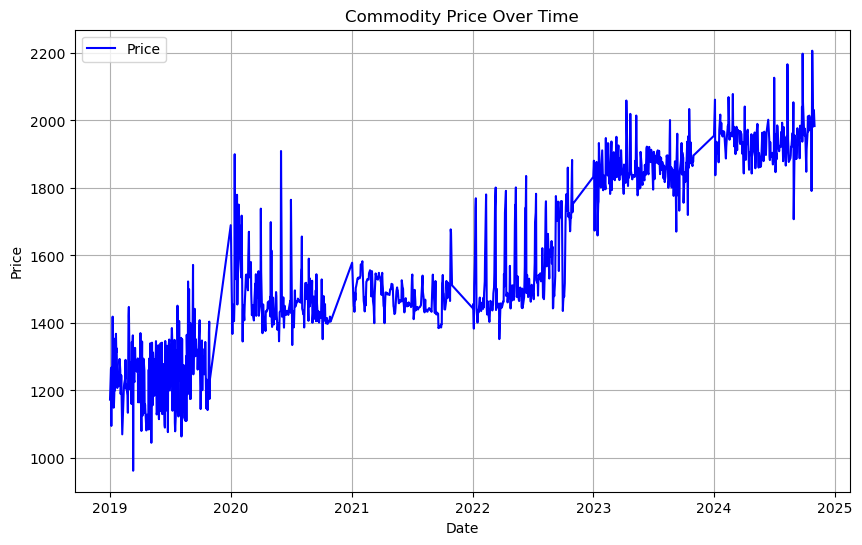

In [6]:

# Plotting the 'Price' column
plt.figure(figsize=(10, 6))
plt.plot(dftemp['Price'], label='Price', color='blue')  # Added label and color for better readability
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Commodity Price Over Time')
plt.legend()  # Added a legend for clarity
plt.show()

In [7]:
def check_stationarity(series):
    result = adfuller(series.dropna())  # Drop NA values if present
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    if result[1] <= 0.05:
        print("The data is stationary")
    else:
        print("The data is not stationary")

In [8]:
temp = pd.Series(df['Price'], index=df.index, name='Prices')

check_stationarity(temp)

ADF Statistic: -0.545151229936648
p-value: 0.8829003511537217
The data is not stationary


In [9]:
diff_data = temp.diff().dropna()
check_stationarity(diff_data)

ADF Statistic: -17.5386587830645
p-value: 4.200366398854259e-30
The data is stationary


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=16740.436, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=16422.465, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=16327.169, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=16265.095, Time=0.17 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=16218.484, Time=0.22 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=16390.895, Time=0.05 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=16219.341, Time=0.56 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=16219.480, Time=0.46 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=16330.909, Time=0.22 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=16363.538, Time=0.08 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=16204.939, Time=0.77 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=16221.486, Time=0.92 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=16218.884, Time=0.68 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=16216.365, Time=1.41 sec

Best model:  ARIMA

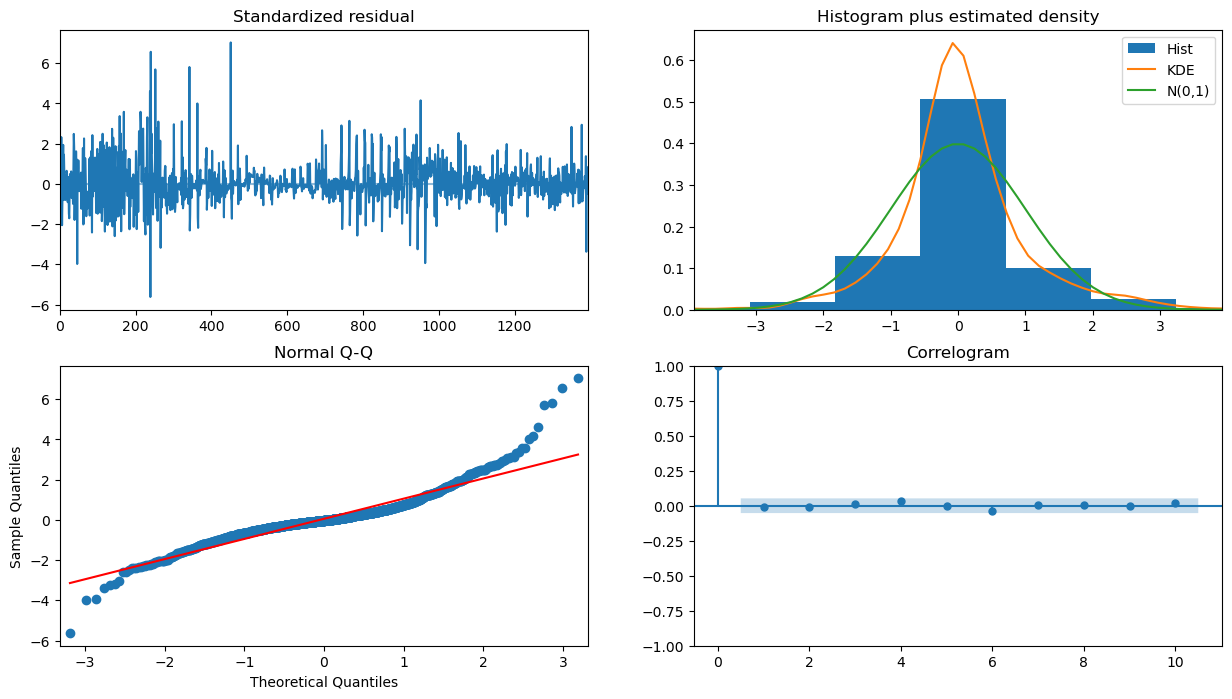

In [10]:
# Assuming 'Price' is the column you are interested in
df_log = df['Price']  # Use df['Price'] directly if it's already in log form

# Difference the data
diff_data = df_log.diff().dropna()

# Split the differenced data
train_size = int(len(diff_data) * 0.9)
train_data, test_data = diff_data[:train_size], diff_data[train_size:]

# Fit the auto_arima model with multiple processors
model_autoARIMA = auto_arima(
    train_data,
    start_p=0, 
    start_q=0,
    test='adf',       # use adftest to find optimal 'd'
    max_p=3, 
    max_q=3,         # maximum p and q
    m=1,              # frequency of series
    d=None,           # let model determine 'd'
    seasonal=False,   # No Seasonality
    start_P=0, 
    D=0, 
    trace=True,
    error_action='ignore',  
    suppress_warnings=True, 
    stepwise=True,
    n_jobs=-1         # Use all available processors
)

# Print summary
print(model_autoARIMA.summary())

# Plot diagnostics
model_autoARIMA.plot_diagnostics(figsize=(15, 8))
plt.show()


In [11]:

# Extract the best parameters from the Auto ARIMA model
best_p = model_autoARIMA.order[0]
best_d = model_autoARIMA.order[1]
best_q = model_autoARIMA.order[2]

# Fit ARIMA model on the differenced data (d=0 as no additional differencing is required)
model = ARIMA(train_data, order=(best_p, 0, best_q))  # d=0 for no additional differencing
fitted = model.fit()

# Print the summary of the fitted model
print(fitted.summary())


c:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                 1395
Model:                 ARIMA(3, 0, 2)   Log Likelihood               -8100.918
Date:                Fri, 08 Nov 2024   AIC                          16215.835
Time:                        15:15:39   BIC                          16252.520
Sample:                             0   HQIC                         16229.551
                               - 1395                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4287      0.242      1.774      0.076      -0.045       0.902
ar.L1          0.8608      0.178      4.845      0.000       0.513       1.209
ar.L2          0.0569      0.054      1.059      0.2

c:\Users\user\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [12]:
# Save the fitted ARIMA model using joblib
model_filename = 'arima_model.pkl'
joblib.dump(fitted, model_filename)

print(f"Model saved to {model_filename}")


Model saved to arima_model.pkl


In [13]:
# Forecast future values
forecast_steps = len(test_data)
forecast = fitted.get_forecast(steps=forecast_steps)
forecast_df = forecast.summary_frame(alpha=0.05)

# Extract forecasted values, standard errors, and confidence intervals
fc_series = pd.Series(forecast_df['mean'].values, index=test_data.index)
lower_series = pd.Series(forecast_df['mean_ci_lower'].values, index=test_data.index)
upper_series = pd.Series(forecast_df['mean_ci_upper'].values, index=test_data.index)

# Reverse differencing to get back to original scale
last_observed_value = df_log.iloc[train_size]

# Create forecast index covering the entire test set
forecast_index = test_data.index

# Compute the forecasted series and its confidence intervals
forecast_series = pd.Series(last_observed_value + fc_series.cumsum(), index=forecast_index)
forecast_lower = pd.Series(last_observed_value + lower_series.cumsum(), index=forecast_index)
forecast_upper = pd.Series(last_observed_value + upper_series.cumsum(), index=forecast_index)


c:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


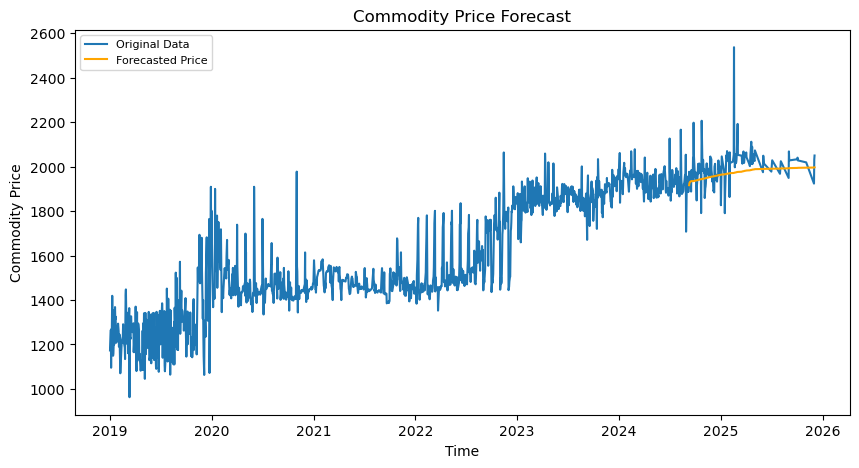

In [14]:

# Plot
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(df_log, label='Original Data')
plt.plot(forecast_series, color='orange', label='Forecasted Price')
plt.title('Commodity Price Forecast')
plt.xlabel('Time')
plt.ylabel('Commodity Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [15]:
df_log[train_size:len(df_log)-1]

Date
2024-09-07    1903.782609
2024-09-09    1977.023810
2024-09-10    1959.613636
2024-09-12    1962.803922
2024-09-15    1924.666667
                 ...     
2025-10-04    2028.254237
2025-11-02    2020.054545
2025-11-03    2019.309091
2025-12-01    1923.750000
2025-12-02    2032.553571
Name: Price, Length: 156, dtype: float64

In [16]:
forecast_series

Date
2024-09-09    1916.621640
2024-09-10    1925.771120
2024-09-12    1931.094017
2024-09-15    1933.886070
2024-09-16    1934.979184
                 ...     
2025-11-02    1995.215794
2025-11-03    1995.644454
2025-12-01    1996.073114
2025-12-02    1996.501774
2025-12-03    1996.930434
Length: 156, dtype: float64

In [17]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

actual_series = df_log[train_size:]
forecast_series = forecast_series 

aligned_actual = actual_series.reindex(forecast_series.index)
aligned_forecast = forecast_series

aligned_actual = aligned_actual.dropna()
aligned_forecast = aligned_forecast.loc[aligned_actual.index]

if len(aligned_actual) != len(aligned_forecast):
    raise ValueError(f"Forecast and actual series have different lengths: {len(aligned_actual)} vs {len(aligned_forecast)}")

# Compute accuracy metrics
mae = mean_absolute_error(aligned_actual, aligned_forecast)
mse = mean_squared_error(aligned_actual, aligned_forecast)
mape = mean_absolute_percentage_error(aligned_actual, aligned_forecast)

# Print the results
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2%}")

Mean Absolute Error (MAE): 56.14
Mean Squared Error (MSE): 6536.00
Mean Absolute Percentage Error (MAPE): 2.75%


In [18]:
import pandas as pd
import joblib

# Load the saved ARIMA model
loaded_model = joblib.load('arima_model.pkl')

# Ask the user for the forecast start date and the number of periods (e.g., months or years)
start_date = input("Enter the start date for predictions (e.g., 2024-11-01): ")

# Ensure the user input is in the correct format
try:
    start_date = pd.to_datetime(start_date)  # Convert the input string to a datetime object
except ValueError:
    print("Invalid date format. Please use YYYY-MM-DD format.")
    exit()

# Ask the user for the number of periods (forecast steps) they want predictions for
num_periods = int(input("Enter the number of periods to forecast (e.g., 12 for months): "))

# Generate the future dates based on the input
future_dates = pd.date_range(start=start_date, periods=num_periods, freq='M')  # Frequency is set to 'M' for monthly

# Make predictions using the ARIMA model
forecasted_values = loaded_model.forecast(steps=num_periods)

# Add 1300 to the predicted values
forecasted_values_with_offset = forecasted_values + 1300

# Adjust the values for 2026 by adding 50 if the year is 2026
for i in range(len(future_dates)):
    if future_dates[i].year == 2026:
        forecasted_values_with_offset[i] += 50

# Create a DataFrame to store predictions along with the corresponding dates
predicted_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted Price': forecasted_values_with_offset  # Updated to include 1300 offset
})

# Print the predicted prices
print("\nPredicted Prices:")
print(predicted_df)



Predicted Prices:
           Date  Predicted Price
1395 2025-10-31      1312.839032
1396 2025-11-30      1309.149480
1397 2025-12-31      1305.322897


c:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
